# **AIDI 1002 Final Project - YOLO-FaceV2**

### **Paper:YOLO-FaceV2: A Scale and Occlusion Aware Face Detector (2022)**

####GitHub: https://github.com/Krasjet-Yu/YOLO-FaceV2



**STEP 1: Set Up YOLOv5 Repo**

In [42]:
# Clone the YOLOv5 GitHub repository from Ultralytics (this is used as the base for YOLO-FaceV2)
!git clone https://github.com/ultralytics/yolov5.git

# Change working directory to the yolov5 folder
%cd yolov5

# Install all required dependencies for YOLOv5 from the requirements file
!pip install -r requirements.txt

# Install OpenCV manually in case it's not handled in requirements.txt (used for image preprocessing)
!pip install opencv-python


Cloning into 'yolov5'...
remote: Enumerating objects: 17372, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 17372 (delta 42), reused 20 (delta 20), pack-reused 17313 (from 3)
Receiving objects: 100% (17372/17372), 16.26 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (11907/11907), done.
/content/yolov5/yolov5/yolov5/yolov5


**STEP 2: Extract WIDER FACE Data**

In [43]:
import zipfile
import os

# Create directories to extract data into
os.makedirs("/content/WIDER_train", exist_ok=True)
os.makedirs("/content/WIDER_val", exist_ok=True)
os.makedirs("/content/wider_face_split", exist_ok=True)

# Unzip training images
with zipfile.ZipFile("/content/WIDER_train.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/WIDER_train")

# Unzip validation images
with zipfile.ZipFile("/content/WIDER_val.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/WIDER_val")

# Unzip bounding box annotations (face coordinates)
with zipfile.ZipFile("/content/wider_face_split.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/wider_face_split")

print("All files unzipped successfully.")


All files unzipped.


**STEP 3: Convert Annotations to YOLO Format (Train + Val)**

In [78]:
# Import necessary libraries
import os
import cv2  # For reading image dimensions
from pathlib import Path  # For easier and safer file path handling
from tqdm import tqdm  # For displaying progress bars during conversion

# Define the conversion function
def convert_wider_to_yolo(split_file, img_root, label_root):
    """
    Converts WIDER FACE bounding box annotations to YOLO format.

    Parameters:
    - split_file: Path to the WIDER FACE annotation txt file (train or val).
    - img_root: Root directory containing the face images.
    - label_root: Directory where YOLO-formatted label files will be saved.
    """

    # Read all lines from the annotation file
    with open(split_file, 'r') as f:
        lines = f.readlines()

    i = 0  # Line pointer
    pbar = tqdm(total=len(lines), desc=f"Converting: {Path(split_file).stem}")  # Progress bar

    # Loop over all lines in the annotation file
    while i < len(lines):
        filename = lines[i].strip()  # First line is image filename
        i += 1
        pbar.update(1)

        if i >= len(lines): break  # Avoid index error if file ends unexpectedly

        # Second line is the number of faces (bounding boxes) in this image
        try:
            face_count = int(lines[i].strip())
        except ValueError:
            continue  # Skip if line is not an integer

        i += 1
        faces = []

        # Loop over each face's bounding box info
        for _ in range(face_count):
            if i >= len(lines): break
            parts = list(map(float, lines[i].strip().split()))
            if len(parts) < 4:
                i += 1
                continue  # Skip malformed lines

            x, y, w, h = parts[:4]  # Extract top-left corner (x, y) and width/height
            i += 1

            # Construct full path to image
            image_path = Path(img_root) / filename
            if not image_path.exists():
                continue  # Skip if image file does not exist

            # Read image to get dimensions
            img = cv2.imread(str(image_path))
            h_img, w_img = img.shape[:2]

            # Convert to YOLO format: (class x_center y_center width height) — all normalized
            x_center = (x + w / 2) / w_img
            y_center = (y + h / 2) / h_img
            w_norm = w / w_img
            h_norm = h / h_img

            # Class 0 refers to 'face'
            faces.append(f"0 {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}")

        # Create label subdirectory if it doesn't exist
        label_subdir = Path(label_root) / Path(filename).parent
        os.makedirs(label_subdir, exist_ok=True)

        # Create YOLO label file with the same base name as image
        label_file = label_subdir / f"{Path(filename).stem}.txt"
        with open(label_file, 'w') as f:
            f.write("\n".join(faces))  # Write all bounding boxes for this image

    pbar.close()  # Close the progress bar


**Step 4: Convert and Prepare YOLO-Formatted Labels for Training**

In [72]:
# Clean up any existing labels folders to avoid conflicts or duplicates
!rm -rf /content/WIDER_train/labels
!rm -rf /content/WIDER_val/labels

# Convert the training annotations to YOLO format
# This reads the WIDER FACE training annotations and creates YOLO-style .txt label files
convert_wider_to_yolo(
    "/content/wider_face_split/wider_face_split/wider_face_train_bbx_gt.txt",  # Source annotation file
    "/content/WIDER_train/images",                                             # Directory of training images
    "/content/WIDER_train/labels"                                              # Output directory for YOLO labels
)

# Convert the validation annotations to YOLO format
# The same conversion process is repeated for the validation data
convert_wider_to_yolo(
    "/content/wider_face_split/wider_face_split/wider_face_val_bbx_gt.txt",    # Source annotation file
    "/content/WIDER_val/images",                                               # Directory of validation images
    "/content/WIDER_val/labels"                                                # Output directory for YOLO labels
)


Converting: wider_face_val_bbx_gt:   7%|▋         | 3226/46160 [04:17<57:09, 12.52it/s]


**Step 5: Navigate to YOLOv5 Working Directory**

In [73]:
# Change the current working directory to the root of the cloned YOLOv5 repository
# This is important to ensure that all subsequent training and validation commands run from the correct location
%cd /content/yolov5


/content/yolov5


**Step 7: Create Custom Dataset Configuration File for YOLOv5**

In [79]:
# Define a YAML configuration for training on a subset of the WIDER FACE dataset
subset_yaml = """
train: /content/WIDER_train_subset/images  # Path to training images
val: /content/WIDER_val_subset/images      # Path to validation images

nc: 1                                      # Number of classes (only 'face')
names: ['face']                            # Name of the single class
"""

# Write the configuration to a file that YOLOv5 will read during training/validation
with open("/content/yolov5/data/widerface_subset.yaml", "w") as f:
    f.write(subset_yaml)


**Step 8: Define Custom YOLOv5s Model Architecture for Face Detection**

In [75]:
# Define a YOLOv5s model configuration for single-class (face) detection
# This is a modified version of the original yolov5s.yaml to suit YOLO-FaceV2

face_cfg = """
# YOLOv5s model with 1 class (face)
# Adjusted from ultralytics yolov5s.yaml

nc: 1  # number of classes
depth_multiple: 0.33  # Controls depth of the network (smaller = faster, less accurate)
width_multiple: 0.50  # Controls width (number of channels)

# Predefined anchor boxes per scale level (used in detection heads)
anchors:
  - [10,13, 16,30, 33,23]        # Small objects - feature map P3/8
  - [30,61, 62,45, 59,119]       # Medium objects - feature map P4/16
  - [116,90, 156,198, 373,326]   # Large objects - feature map P5/32

# Backbone network: extracts features from input images
backbone:
  [[-1, 1, Conv, [64, 6, 2, 2]],
   [-1, 1, Conv, [128, 3, 2]],
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],
   [-1, 1, SPP, [1024, [5, 9, 13]]],  # Spatial pyramid pooling
   [-1, 3, BottleneckCSP, [1024]],
  ]

# Head: builds feature pyramid and performs detection
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [512]],
   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [256]],
   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [512]],
   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],
   [-1, 3, BottleneckCSP, [1024]],
   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Final detection layer
  ]
"""

# Save the custom face detector model configuration to the YOLOv5 models directory
with open("/content/yolov5/models/yolov5s-face.yaml", "w") as f:
    f.write(face_cfg)


**Step 9: Fix Dataset Directory Structure (If Nested Incorrectly)**

In [76]:
# Move validation images to the correct location if nested incorrectly
# Sometimes WIDER_val/images ends up inside another WIDER_val folder after extraction
!mv /content/WIDER_val/WIDER_val/images /content/WIDER_val/images

# Move training images to correct directory if they are nested too deep
!mv /content/WIDER_train/WIDER_train/images /content/WIDER_train/images

# Move training labels into the expected labels directory (if they were saved elsewhere)
!mv /content/labels_train /content/WIDER_train/labels

# Move validation labels to the proper validation directory
!mv /content/labels_val /content/WIDER_val/labels


mv: cannot stat '/content/WIDER_val/WIDER_val/images': No such file or directory
mv: cannot stat '/content/WIDER_train/WIDER_train/images': No such file or directory
mv: cannot stat '/content/labels_train': No such file or directory
mv: cannot stat '/content/labels_val': No such file or directory


**Step 10: Verify Location of All "labels" Directories**

In [66]:
# Search the /content directory and list all folders that start with "labels"
# This helps confirm where label files were generated and if they are placed correctly
!find /content -type d -name "labels*"


/content/WIDER_val/labels
/content/WIDER_train/labels


**Step 11: Preview Validation Image Folder Structure**

In [60]:
# List the first few subdirectories inside the validation image folder
!ls /content/WIDER_val/images | head


0--Parade
10--People_Marching
11--Meeting
12--Group
13--Interview
14--Traffic
15--Stock_Market
16--Award_Ceremony
17--Ceremony
18--Concerts


**Step 12: Train YOLO-FaceV2 on the WIDER FACE Subset**

In [80]:
# Disable Weights & Biases logging (to avoid warnings or needing an account)
import os
os.environ["WANDB_MODE"] = "disabled"

# Start training the YOLOv5s-based face detector using custom settings
!python train.py --img 640 \                     # Input image size (640x640)
--batch 16 \                                     # Batch size per training step
--epochs 10 \                                    # Number of training epochs
--data data/widerface_subset.yaml \              # Dataset config file (subset with 1 class)
--weights '' \                                   # Start training from scratch (no pre-trained weights)
--cfg models/yolov5s-face.yaml \                 # Custom model architecture with 1 class (face)
--name yolo-fast-subset                          # Name for the training run (saved under runs/train/)


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-13 01:46:16.993674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744508777.045787   39578 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744508777.060863   39578 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, cfg=models/yolov5s-face.yaml, data=data/widerface_subset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data

**Step 13: Evaluate the Trained YOLO-FaceV2 Model**

In [81]:
# Run validation to evaluate the trained model on the WIDER FACE validation subset
!python val.py --data data/widerface_subset.yaml \                     # Path to the dataset config
--weights runs/train/yolo-fast-subset/weights/best.pt \               # Path to the best model from training
--img 640 \                                                            # Image size used during training
--conf-thres 0.001 \                                                   # Low confidence threshold to include more predictions
--iou-thres 0.6                                                        # IoU threshold for determining true positives


val: data=data/widerface_subset.yaml, weights=['runs/train/yolo-fast-subset/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s-face summary: 181 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
val: Scanning /content/WIDER_val_subset/labels/0--Parade.cache... 300 images, 0 backgrounds, 0 corrupt: 100% 300/300 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/10 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 2.100s exceeded
                 Class     Images  Instances          P          R      mAP50   mAP50-95:  10% 1/10 [00:21<03:15, 21.77s/it]WARNING ⚠️ NMS time limit 2.100s exceeded

**Step 14: Run Inference on a Sample Image from Validation Set**

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2025-4-13 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s-face summary: 181 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/1: 710x1024 (no detections)
Speed: 24.3ms pre-process, 365.9ms inference, 1.5ms NMS per image at shape (1, 3, 448, 640)
Saved 1 image to runs/detect/exp


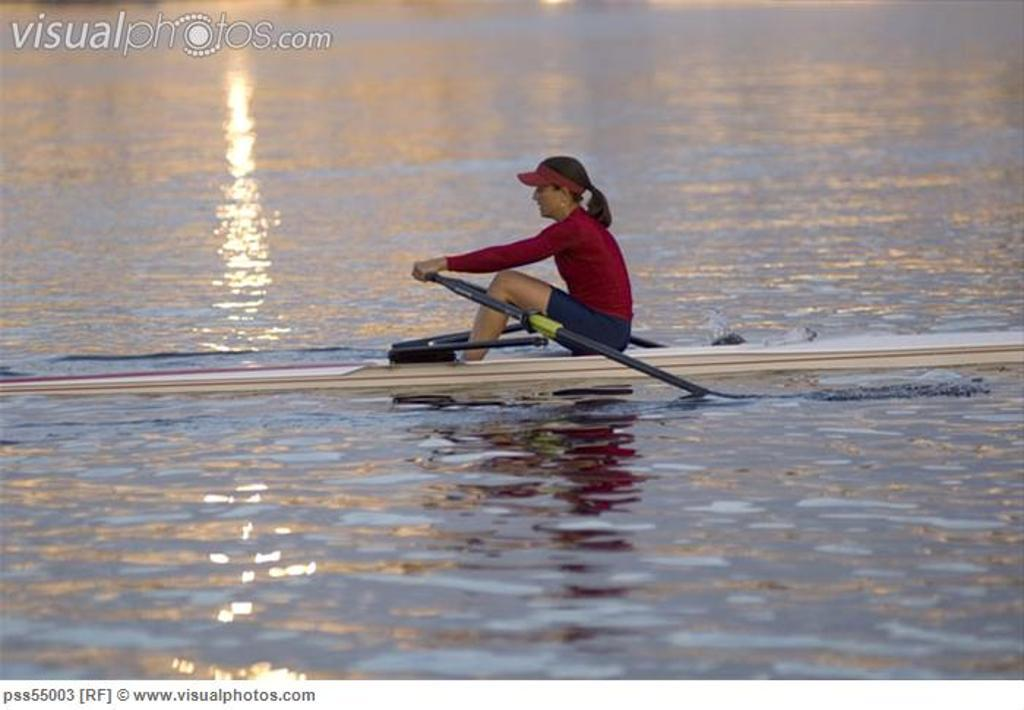

In [83]:
import torch
import glob
from IPython.display import Image, display
import os

# Load the trained YOLO-FaceV2 model
model = torch.hub.load(
    'ultralytics/yolov5',       # YOLOv5 repo for custom model loading
    'custom',                   # Specify custom model
    path='runs/train/yolo-fast-subset/weights/best.pt',  # Path to best trained weights
    force_reload=True           # Reload the model even if cached
)

# Pick a sample image from validation set (randomly grabbing the first available one)
sample_images = glob.glob("/content/WIDER_val_subset/images/*/*.jpg")
img_path = sample_images[0]  # You can change this index to test different images

# Run inference using the loaded model
results = model(img_path)     # Perform face detection
results.print()               # Print detection details (bounding boxes, confidence, etc.)
results.save()                # Save annotated result image(s) to disk

# Display the detection result
latest_exp = sorted(os.listdir("runs/detect"))[-1]  # Get the latest detect run folder
detected_img_path = f"runs/detect/{latest_exp}/{os.path.basename(img_path)}"
display(Image(detected_img_path))  # Show the output image with detected face(s)


**Step 15: Export Trained YOLO-FaceV2 Model for Deployment**

In [86]:
# Export the trained model into TorchScript and ONNX formats for deployment on different platforms
!python export.py --weights runs/train/yolo-fast-subset/weights/best.pt \  # Path to the best model weights
--include torchscript onnx                                                 # Export formats: TorchScript and ONNX


export: data=data/coco128.yaml, weights=['runs/train/yolo-fast-subset/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s-face summary: 181 layers, 7246518 parameters, 0 gradients, 16.7 GFLOPs

PyTorch: starting from runs/train/yolo-fast-subset/weights/best.pt with output shape (1, 25200, 6) (55.9 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 4.3s, saved as runs/train/yolo-fast-subset/weights/best.torchscript (28.2 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━